<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/Grid_Test_Knock_Out_Call_1stock_Monte_Carlo_SGD_Judy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 8)
K_range = jnp.linspace(0.75, 1.25, 5)
B_range = jnp.linspace(0.5, 1.0, 5)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(B_range)
print(sigma_range)
print(r_range)

[0.75       0.82142854 0.89285713 0.9642857  1.0357143  1.1071429
 1.1785713  1.25      ]
[0.75  0.875 1.    1.125 1.25 ]
[0.5   0.625 0.75  0.875 1.   ]
[0.15       0.25       0.35000002 0.45      ]
[0.01  0.025 0.04 ]


In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 8)
K_range = jnp.linspace(0.75, 1.25, 5)
B_range = jnp.linspace(0.5, 1.0, 5)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []
count = 0

for S in S_range:
  for K in K_range:
    for B in B_range:
      for r in r_range:
        for sigma in sigma_range:    

          initial_stocks = jnp.array([S]*numstocks) # must be float
          r_tmp = jnp.array([r]*numstocks)
          drift = r_tmp
          cov = jnp.identity(numstocks)*sigma*sigma

          European_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          call.append([T, K, B, S, sigma, r, r, European_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
          
          count += 1
          print(count)

In [ ]:
Thedataset = pd.DataFrame(call)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.04829822,0.555157
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.07776406,0.563845
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.10653644,0.572229
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.13306102,0.569618
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.053997554,0.594301
...,...,...,...,...,...,...,...,...,...
2395,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.19972013,0.471407
2396,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.10002679,0.631672
2397,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.1442415,0.583131
2398,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.17972831,0.529840


In [ ]:
# save to csv
Thedataset.to_csv('Knock_Out_Call_1stock_MC_Datset_v2.csv', index=False, header=False)

In [1]:
# read csv
import pandas as pd

Thedataset = pd.read_csv('Knock_Out_Call_1stock_MC_Datset.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.048510,0.556664
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.078121,0.565542
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.107045,0.574232
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.133747,0.572047
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.054222,0.595631
...,...,...,...,...,...,...,...,...,...
1531,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.200693,0.473159
1532,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.100417,0.632826
1533,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.144892,0.584785
1534,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.180591,0.531644


# Construct Neural Net

In [8]:
%%writefile cupy_dataset.py
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)
Thedataset = pd.read_csv('Knock_Out_Call_1stock_MC_Datset.csv', header=None)
Thedataset_X = Thedataset.iloc[:,:7]
Thedataset_Y = Thedataset.iloc[:,7:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

Overwriting cupy_dataset.py


In [3]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.5, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 11.7 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import SGD
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=1e-3) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)
    # print(y_pred)
    # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.16174215223005395 average time 2.2934526660999976 iter num 20
loss 0.1617256477824784 average time 2.299380876074996 iter num 40
loss 0.16171492063456486 average time 2.2979287415333287 iter num 60
loss 0.1617101558535418 average time 2.302521453024993 iter num 80
loss 0.161709307860244 average time 2.302753612559995 iter num 100
loss 0.16169058947380333 average time 2.3104833722499962 iter num 20
loss 0.16167429650592863 average time 2.314886290949997 iter num 40
loss 0.16166370761925225 average time 2.305634159400002 iter num 60
loss 0.16165900470564598 average time 2.305852455274997 iter num 80
loss 0.16165817057276746 average time 2.3070976614699963 iter num 100
loss 0.16163969375786463 average time 2.3321345370500013 iter num 20
loss 0.16162360449203816 average time 2.3266342223249894 iter num 40
loss 0.16161314989061254 average time 2.334613928066659 iter num 60
loss 0.1616085070680938 average time 2.3296324320999973 iter num 80
loss 0.16160768634108144 average time 2.3252

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# 2hr 30min

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import torch
model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_5.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import torch
model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_4.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [24]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)


**Continue to train model**

In [13]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import SGD
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=1e-3) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_2.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.15995504071374575 average time 2.2831595504999314 iter num 20
loss 0.15994484471269058 average time 2.304582312550019 iter num 40
loss 0.15993822204433816 average time 2.310298074066668 iter num 60
loss 0.15993532686431042 average time 2.310493552337448 iter num 80
loss 0.15993488526681204 average time 2.3114961413299717 iter num 100
loss 0.15992329688617815 average time 2.2744791073999293 iter num 20
loss 0.15991319145485988 average time 2.276531232374964 iter num 40
loss 0.15990662736296946 average time 2.283996195199961 iter num 60
loss 0.15990376008997123 average time 2.2919434673499834 iter num 80
loss 0.15990332323640477 average time 2.2933436218300085 iter num 100
loss 0.15989184081389507 average time 2.2939314872998695 iter num 20
loss 0.15988182380219002 average time 2.3117554854998614 iter num 40
loss 0.15987531777649905 average time 2.3219858975499847 iter num 60
loss 0.15987248059239306 average time 2.316892886612391 iter num 80
loss 0.1598720492473847 average time 2

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# 6hr 8 min

## Continued Continued to train model

In [17]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import SGD
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=1e-3) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_3.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.15771566553396593 average time 2.3652323660004186 iter num 20
loss 0.15770966257319627 average time 2.3419441313748393 iter num 40
loss 0.1577057917298616 average time 2.3224139882330443 iter num 60
loss 0.15770417837201653 average time 2.3207987988622336 iter num 80
loss 0.15770399792329626 average time 2.31961428754963 iter num 100
loss 0.15769714524055517 average time 2.322695706949162 iter num 20
loss 0.15769115886632412 average time 2.3343088916743 iter num 40
loss 0.15768730143791276 average time 2.323199258382859 iter num 60
loss 0.15768569190628015 average time 2.334309038574702 iter num 80
loss 0.15768551187720256 average time 2.322863323199781 iter num 100
loss 0.15767867937335941 average time 2.250401875799798 iter num 20
loss 0.1576727135561756 average time 2.286921439324942 iter num 40
loss 0.15766886769860777 average time 2.2905765453331695 iter num 60
loss 0.15766726359972724 average time 2.293932866212617 iter num 80
loss 0.15766708380667305 average time 2.298243

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
#1hr 16min

## Continued Continued Continued Train

In [21]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import SGD
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=1e-3) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 200)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_4.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.15733865396808083 average time 2.2630760662006653 iter num 20
loss 0.15733297865382898 average time 2.3097834692003745 iter num 40
loss 0.15732932184406864 average time 2.320877319767048 iter num 60
loss 0.15732780719064482 average time 2.3217156298003827 iter num 80
loss 0.1573276424550325 average time 2.3173264616005325 iter num 100
loss 0.15732114961906601 average time 2.309592571050234 iter num 20
loss 0.15731548459343023 average time 2.2918997797756675 iter num 40
loss 0.1573118363721942 average time 2.2884598610334552 iter num 60
loss 0.1573103263776297 average time 2.2874198805127888 iter num 80
loss 0.1573101632905118 average time 2.2762016343503637 iter num 100
loss 0.15730368310509996 average time 2.2491593338501845 iter num 20
loss 0.15729803182966218 average time 2.2633440056997642 iter num 40
loss 0.15729439229779213 average time 2.250903064083468 iter num 60
loss 0.1572928858409673 average time 2.255341844525174 iter num 80
loss 0.1572927233416173 average time 2.26

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
#8hr 46min

## Continued Continued Cotinued Continued to Train

In [26]:
#version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import SGD
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=1e-3) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[3]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 200)

model_save_name = 'jax_knock_out_1stock_MC_oneDS_SGD_5.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.1551493713217277 average time 2.312431484249828 iter num 20
loss 0.1551445366934691 average time 2.301714130775872 iter num 40
loss 0.15514141843443022 average time 2.299632771649825 iter num 60
loss 0.15514014690407263 average time 2.2944758533500136 iter num 80
loss 0.15514001780460712 average time 2.2875134562005406 iter num 100
loss 0.15513447482661546 average time 2.291360321199318 iter num 20
loss 0.15512964557859607 average time 2.2774691356255063 iter num 40
loss 0.1551265281878329 average time 2.276994114849852 iter num 60
loss 0.15512525723614856 average time 2.2676163488122256 iter num 80
loss 0.15512512725477803 average time 2.2615672990200983 iter num 100
loss 0.15511958873421375 average time 2.2560817708988905 iter num 20
loss 0.15511476086118403 average time 2.2847189782485655 iter num 40
loss 0.155111646206497 average time 2.2725993852659787 iter num 60
loss 0.15511037642139694 average time 2.2740542812118294 iter num 80
loss 0.15511024676305063 average time 2.27

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# 1hr 49min

#Results

In [ ]:
import torch
inputs = torch.tensor([[1, 1, 0.8, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, B, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[3]]

# price, delta
# should be around (0.10632345, 0.5543747)

price: tensor([[0.101666]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.591832], device='cuda:0')

In [ ]:
# Knock out call

# now change code such that 'numsteps' does not represent year
# make dt = year / numsteps
# Add r, and notice that noise must have mean 0, not drift, or else it'll give large option prices
# (done)
# after making the changes, the values are still correct

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(1)
rng, key = jax.random.split(rng)

drift = jnp.array([0.02]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0
B = 0.8 # if B is set to 0, equivalent to European call

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

0.10632345
[0.5543747]


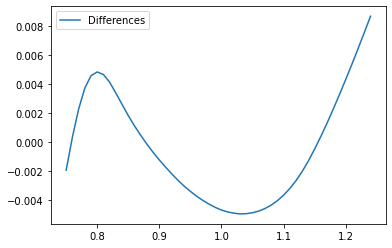

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_price(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "correct_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

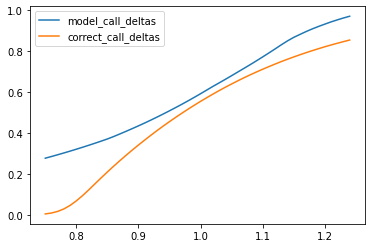

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][3]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.0, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

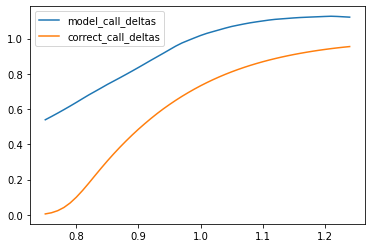

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][3]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 0.775, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

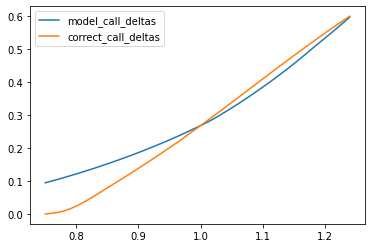

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][3]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.225, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()